# City of Seattle - Negative Rain Event Forecasting

** Daniel White - December 21, 2018 **

## Overview

This notebook trains a model on existing observed rainfall data in the Seattle area to predict days with a large number of work orders. The purpose of the analysis is to enable more accurate predictions about weather events that will negatively impact the city, better preparing maintenance dispatch operators to respond to these events.

## Notebook Setup

This section includes changes to notebook settings and Python package imports.

In [1]:
#Change notebook setting to show multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import packages
import numpy as np
import pandas as pd
from time import time


import sys
import os
import sklearn
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

## Data Cleaning

The analysis historical hourly rain data from the City of Seattle. This dataset includes hourly precipitation readings from rain gauges across Seattle between from October 2002 to May 2017. The second dataset is a history of Maximo work orders tickets filed since from November 2006 to March 2018.

### Hourly Rain Data Processing

The code block below imports the hourly rain data and combines it into a single dataframe. The average hourly precipitation across all rain gauges is calculated. Since, forecast data is not available by rain gauge location, this will be used as the main metric for assessing rainfall.

In [3]:
#Load hourly rain data
hrly_dict = {}
for i in range(2003,2018):
    dfname = 'rgHRLY' + str(i) + 'df'
    hrly_dict[i] =  dfname

for i in range(2003,2018):
    csvname =  'data-private/Rainfall_HRLY/'+ str(i) + 'HRLY.csv'
    hrly_dict[i] = pd.read_csv(csvname, low_memory=False)

hrlyrain = pd.DataFrame()
for i in range(2003,2018):
    hrlyrain = hrlyrain.append(hrly_dict[i])
    
hrlyrain = hrlyrain.set_index('time')
hrlyrain.index = pd.to_datetime(hrlyrain.index)
del hrly_dict

#Compute average of all rain gauge stations, for one precipitation measure.
hrlyrain['avghr'] = hrlyrain[hrlyrain.columns[0:17]].mean(axis=1)
rain_df = pd.DataFrame(hrlyrain['avghr'])
rain_df.head()

,avghr
time,
2002-10-01 08:00:00,0.0
2002-10-01 09:00:00,0.0
2002-10-01 10:00:00,0.0
2002-10-01 11:00:00,0.0
2002-10-01 12:00:00,0.0


NAEFS Forecast Data provides forecasted rainfall as accumulated preciptation over 6 hour periods. Therefore, the historical hourly data is combined into 6 hour periods for consistency with the available forecast data.

In [4]:
# Function that takes in the datetime, returns a period designation consistent with the forecast data.
def group_6hrs(datetime):
    """
    Converts hour of day into a period designation (0,6,12,18)
    The 6 hour period refers to the six hours prior to the period number
    6: 12am-6am
    12: 6am-12pm
    18: 12pm-6pm
    0: 6pm-12pm
    """
    hour = datetime.hour
    if hour < 6:
        period = 6
    elif hour >= 6 and hour < 12:
        period = 12
    elif hour >= 12 and hour < 18:
        period = 18
    else:
        period = 0
    return period

In [5]:
#Create day and period columns based on datetime
rain_df = rain_df.reset_index()
rain_df['period'] = rain_df['time'].apply(group_6hrs)
rain_df['day'] = rain_df['time'].map(lambda x:  x.date())
rain_df = rain_df.set_index('time')

#Sum hourly rainfall over period and day, round to 3 decimals
period_df = pd.DataFrame(rain_df.groupby(['day','period'], as_index = False)['avghr'].sum())
period_df = period_df.rename(columns = {'avghr' : 'total_rain'})
period_df['total_rain'] = round(period_df['total_rain'],3)
period_df.head()

,day,period,total_rain
0,2002-10-01,0,0.000
1,2002-10-01,12,0.000
2,2002-10-01,18,0.001
3,2002-10-02,0,0.000
4,2002-10-02,6,0.000


## Maximo Work Orders Data

The Maximo work order ticket data is imported here and aggregated by the day. The result is a dataframe with the day and the number of work order tickets filed on that day.

In [6]:
###############
# LOAD MAXIMO DATA
###############

#Counts the number of work orders per day

##load MAXIMO data
maximodata = pd.read_csv('data-private/20180320_Rainfall_MAXIMO.csv', low_memory=False)
# maximodata.columns.to_series().groupby(maximodata.dtypes).groups
maximodata["SR_REPORT_DATE"] = pd.to_datetime(maximodata["SR_REPORT_DATE"])
maximodata["WO_REPORTDATE"] = pd.to_datetime(maximodata["WO_REPORTDATE"])
maximodata["SR_REPORT_YEAR"] = maximodata['SR_REPORT_DATE'].dt.year


#groupby date, rewritten by Dan to avoid multi-indexing
maximo_tms = maximodata.groupby(['SR_REPORT_DATE'])['TICKETID'].agg(['nunique'])


#make uniform ts
maximo_tms = maximo_tms.asfreq('d')
#maximo_tms.columns.to_series().groupby(maximo_tms.dtypes).groups
maixmo_tms = maximo_tms.apply(pd.to_numeric)
#maximo_tms = maximo_tms.astype(float)
maximo_tms = maximo_tms.fillna(0) 
maximo_tms.rename(columns = {'nunique' : 'work_orders'}, inplace = True)

## Assessment of Previous Method (Two Inches in Twenty Four Hours)

The previous benchmark for a rain event that would negatively impact the city was a 2 inches of precipitation in 24 hour. Using the historical rain data, I assessed the accuracy of this benchmark in predicting days with a high number of work orders. I also explored the accuracy of a 1 inch in 24 hour heuristic to assess whether it was was a better indicator of days with high work orders.

In [7]:
#Calculate the precipitation over previous 24 hours from the historical hourly data
titf = rain_df.copy()
titf['rolling_rain'] = titf['avghr'].rolling(window = 24).sum()

#Take the max 24-hour rolling sum of precipitation for each day, round to 3 decimals
titf_day = pd.DataFrame(titf.groupby('day')['rolling_rain'].max())
titf_day['rolling_rain'] = titf_day['rolling_rain'].map(lambda x: round(x,3))

# Create 1 and 2 inches in 24 hour heuristics
titf_day['titf2'] = np.where(titf_day['rolling_rain'] >= 2, 1,0)
titf_day['titf1'] = np.where(titf_day['rolling_rain'] >= 1, 1,0)

#Merge with work orders dataset, generate flags for days with a high number of work orders
titf_df = pd.merge(titf_day, maximo_tms, how = 'inner', left_index = True, right_index = True)
y_rule = titf_df['work_orders'].quantile(.9)
titf_df['work_orders'] = np.greater(titf_df['work_orders'], y_rule)*1

In [8]:
titf_conf = confusion_matrix(titf_df['work_orders'], titf_df['titf2'])
print('2 inches in 24 hours')
print(pd.DataFrame(titf_conf,
                   columns=['pred_neg', 'pred_pos'], 
                   index=['neg', 'pos']))

tn, fp, fn, tp = titf_conf.ravel()

print('Model Score: ', (tp + tn) / np.sum(titf_conf))

#Of the predicted positives, how many were correct
print('Model Precision: ', tp/ (tp + fp))

#How many actual positives did we predict correctly.
print('Model Recall Rate: ', tp / (tp + fn))

titf_conf = confusion_matrix(titf_df['work_orders'], titf_df['titf1'])
print('\n', '1 inch in 24 hours')
print(pd.DataFrame(titf_conf,
                   columns=['pred_neg', 'pred_pos'], 
                   index=['neg', 'pos']))

tn, fp, fn, tp = titf_conf.ravel()

print('Model Score: ', (tp + tn) / np.sum(titf_conf))

#Of the predicted positives, how many were correct
print('Model Precision: ', tp/ (tp + fp))

#How many actual positives did we predict correctly.
print('Model Recall Rate: ', tp / (tp + fn))

2 inches in 24 hours
     pred_neg  pred_pos
neg      3460         0
pos       360        11
Model Score:  0.9060297572435395
Model Precision:  1.0
Model Recall Rate:  0.029649595687331536

 1 inch in 24 hours
     pred_neg  pred_pos
neg      3409        51
pos       280        91
Model Score:  0.9135995823544767
Model Precision:  0.6408450704225352
Model Recall Rate:  0.24528301886792453


### Results

**2 Inches in 24 Hours**

The results of this assessment show that the 2 in 24 hours rule applied to only 11 days in the 12 year sample. When this heuristic was applied, it was 100% correct. However, it only correctly predicted less than 3% of the events that actually occurred. The historical data shows that this metric is overly conservative and more negative events can be correctly identified with a more sophisticated prediction system improvements.

**1 Inch in 24 Hours**

For the sake of comparison, the performance of a 1 inch in 24 hour heuristic was tested. This had a lower rate of precision, with 65% accuracy on its predictions of negative rain events, but it did identify about 25% of the negative events that actually occurred.

**Alternative Methods**

These heuristics are easy to apply, but their accuracy can be greatly improved with a statistic model. In the following sections, a predictive model is constructed based on available NAEFS forecast data to predict negative rain events in the Seattle region.

## Feature Engineering

The first step is to create model features that could be predictive in determining negative rain events. There are several limitations to these features that should be noted.

* **NAEFS forecast data provides accumulated rainfall over 6 hour periods**

Thus, the historical hourly rainfall data was aggregated into 6 hour sums for developing the model.

* **Actual observed rainfall from previous days is not readily available fron NAEFS** 
Including rolling sums rainfall as a predictor variable results in complications with the forecast data since this data is not available. Making next day predictions is impossible without the actual observed rainfall, which is an intended use case for the model.

The function below generates features to be used in the model from the historical rain forecast dataset. Any future modifications to features should be made in this function to ensure consistency in transformations on the historical data and forecast data. 

** Feature dictionary: **


|Name      | Description |
|-----     | -----       |
| total_rain | total daily rainfall (inches)|
| p>0.5 | The number of periods in a day with rainfall over 0.5 inches. |
| p>0.3 | The number of periods in a day with rainfall over 0.3 inches. |
| p>0.07 | The number of periods in a day with rainfall over 0.07 inches. |
| p>0.005 | The number of periods in a day with rainfall over 0.005 inches. |
| p>0 | The number of periods in a day with rainfall over 0 inches. |
| p_max | The maximum observed amount of rainfall in a period in a single day|
| dow_0-6 | Day of the Week (0-Mon, 1-Tues, etc.) |

In [9]:
def generate_features(df):
    """Takes in a dataframe that includes the date and total precipitation per 6 hour period
    The function is designed to be applied to both the forecast and training dataset to generate the features
    for the model. Any changes to features should be made here for consistency across the two data sources."""
    
    #Selected 0.5 as the 95th percentile in training data
    df['p>0.5'] = np.where(df['total_rain'] > 0.5, 1,0)
    
    #Selected 0.3 as the 90th percentile in training data
    df['p>0.3'] = np.where(df['total_rain'] > 0.3, 1,0)
    
    #Selected 0.07 as 90th percentile in training data
    df['p>0.07'] = np.where(df['total_rain'] > 0.07, 1,0)
    
    #Selected #0.005 as 75th percentile in training data
    df['p>0.005'] = np.where(df['total_rain'] > 0.005, 1,0)
    
    df['p>0'] = np.where(df['total_rain'] > 0.0, 1,0)
    
    daily_df = pd.DataFrame(df.groupby(['day']).sum())
    daily_df['pmax'] = df.groupby('day')['total_rain'].max()
    
    #Create day of the week indicator variables
    daily_df['dow'] = daily_df.index.map(lambda x : x.weekday())
    daily_df = pd.get_dummies(daily_df, columns = ['dow'])
    del daily_df['period']
    return daily_df

The features are generated for the historical dataset in the code block below. A correlation table is between the features is also presented.

In [10]:
historical_rain_df = generate_features(period_df)
historical_rain_df.head()
historical_rain_df.corr()

,total_rain,p>0.5,p>0.3,p>0.07,p>0.005,p>0,pmax,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
day,,,,,,,,,,,,,,
2002-10-01,0.001,0,0,0,0,1,0.001,0,1,0,0,0,0,0
2002-10-02,0.000,0,0,0,0,0,0.000,0,0,1,0,0,0,0
2002-10-03,0.401,0,0,2,3,3,0.274,0,0,0,1,0,0,0
2002-10-04,0.001,0,0,0,0,1,0.001,0,0,0,0,1,0,0
2002-10-05,0.020,0,0,0,1,2,0.016,0,0,0,0,0,1,0


,total_rain,p>0.5,p>0.3,p>0.07,p>0.005,p>0,pmax,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
total_rain,1.000000,0.700007,0.824313,0.834806,0.659660,0.509568,0.951191,0.004175,-0.016109,0.012742,-0.003424,0.006451,-0.007604,0.003770
p>0.5,0.700007,1.000000,0.668114,0.370683,0.233272,0.165800,0.657977,0.018933,-0.014970,0.015851,-0.008806,-0.005724,-0.005724,0.000440
p>0.3,0.824313,0.668114,1.000000,0.569338,0.387071,0.277548,0.792104,-0.004378,-0.009216,0.024653,0.000461,-0.001152,-0.007603,-0.002765
p>0.07,0.834806,0.370683,0.569338,1.000000,0.731645,0.570960,0.794739,-0.015128,-0.013836,0.008117,-0.000922,0.021031,-0.008671,0.009409
p>0.005,0.659660,0.233272,0.387071,0.731645,1.000000,0.821738,0.655171,-0.003976,-0.002362,-0.001152,-0.003169,0.005704,-0.004782,0.009738
p>0,0.509568,0.165800,0.277548,0.570960,0.821738,1.000000,0.522806,0.000049,0.000049,0.004545,0.004200,-0.004101,-0.005484,0.000741
pmax,0.951191,0.657977,0.792104,0.794739,0.655171,0.522806,1.000000,0.005660,-0.022245,0.016323,-0.009148,0.010495,0.001428,-0.002512
dow_0,0.004175,0.018933,-0.004378,-0.015128,-0.003976,0.000049,0.005660,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
dow_1,-0.016109,-0.014970,-0.009216,-0.013836,-0.002362,0.000049,-0.022245,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667
dow_2,0.012742,0.015851,0.024653,0.008117,-0.001152,0.004545,0.016323,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667


Next, the X and y dataframes for modeling are created below. The Maximo work orders dataset is merged with the precipitation data matching the corresponding day. The y array is transformed into an indicator variable that flags days that had work orders above the value at the 90th percentile value.

In [11]:
# Create X and y variables
df = pd.merge(historical_rain_df, maximo_tms, how = 'inner', left_index = True, right_index = True)
df.corr()
y = np.array(df['work_orders'])
y_rule = df['work_orders'].quantile(.9)
y = np.greater(y, y_rule)*1
del df['work_orders']
X = df.fillna(0)

,total_rain,p>0.5,p>0.3,p>0.07,p>0.005,p>0,pmax,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,work_orders
total_rain,1.000000,0.718917,0.829437,0.830189,0.662935,0.522472,0.948384,0.011366,-0.020637,0.019792,0.000637,0.000767,-0.013703,0.001769,0.654732
p>0.5,0.718917,1.000000,0.688575,0.382204,0.254599,0.184247,0.682938,0.008896,-0.030271,0.028648,-0.006703,0.001152,-0.002775,0.001046,0.572950
p>0.3,0.829437,0.688575,1.000000,0.575458,0.402407,0.296924,0.793296,-0.005246,-0.011398,0.037111,0.005475,-0.000853,-0.015617,-0.009461,0.487633
p>0.07,0.830189,0.382204,0.575458,1.000000,0.739691,0.592053,0.786019,-0.001876,-0.013611,0.009749,0.003693,0.005423,-0.010150,0.006769,0.381271
p>0.005,0.662935,0.254599,0.402407,0.739691,1.000000,0.842253,0.655301,0.014361,0.000409,-0.006309,0.000969,-0.005189,-0.015266,0.011005,0.271569
p>0,0.522472,0.184247,0.296924,0.592053,0.842253,1.000000,0.537618,0.002505,0.006181,0.004265,0.004744,-0.013934,-0.010582,0.006812,0.207168
pmax,0.948384,0.682938,0.793296,0.786019,0.655301,0.537618,1.000000,0.013728,-0.026868,0.022291,-0.003831,0.007500,-0.005017,-0.007808,0.582481
dow_0,0.011366,0.008896,-0.005246,-0.001876,0.014361,0.002505,0.013728,1.000000,-0.166743,-0.166743,-0.166743,-0.166743,-0.166743,-0.166920,0.089023
dow_1,-0.020637,-0.030271,-0.011398,-0.013611,0.000409,0.006181,-0.026868,-0.166743,1.000000,-0.166565,-0.166565,-0.166565,-0.166565,-0.166743,0.053247
dow_2,0.019792,0.028648,0.037111,0.009749,-0.006309,0.004265,0.022291,-0.166743,-0.166565,1.000000,-0.166565,-0.166565,-0.166565,-0.166743,0.057851


### Negative Rain Events and Day of Week

One of the features not related to rain included in the model was the day of the week. As the chart below shows, historically, more negative events with the most work orders occurred on weekdays, with very few on weekends. Thus, dummy variables for day of the week were included in the model.

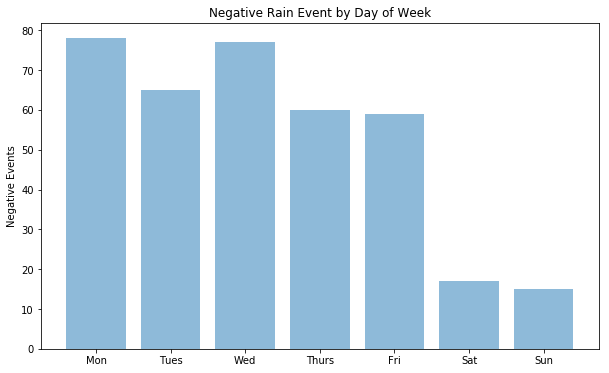

In [12]:
df['dow'] = df.index.map(lambda x : x.weekday())
df['work_orders'] = y
dow = pd.DataFrame(df.groupby('dow')['work_orders'].sum())
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10,6))
plt.bar(dow.index, dow.work_orders, align='center', alpha=0.5)
plt.xticks(dow.index, days)
plt.ylabel('Negative Events')
plt.title('Negative Rain Event by Day of Week')
plt.show();


The plot below shows negative rain events and normal days on a plot of rainfall volume vs. intensity. Negative rain events occur more frequently on days with more rainfall, however, the science of predicting negative rain events is not easy. There is a great deal of overlap between the negative rain events and normal days.

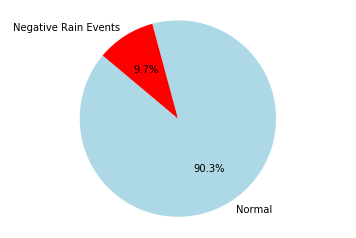

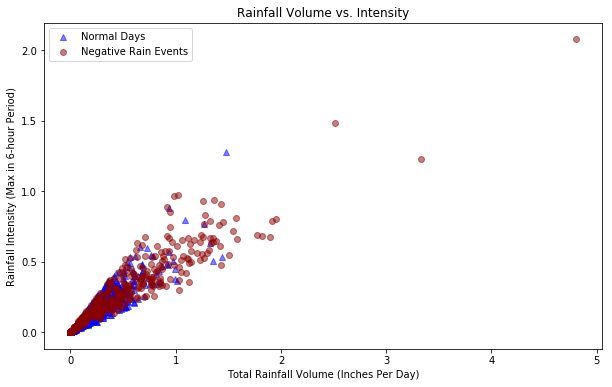

In [13]:
#Filter on negative rain event flag
scatter_df = df[['total_rain', 'pmax', 'work_orders']]
scatter_df0 = scatter_df[(scatter_df['work_orders'] == 0)]
scatter_df1 = scatter_df[(scatter_df['work_orders'] == 1)]

#Make pie chart
labels = ['Normal', 'Negative Rain Events']
sizes = [len(scatter_df0), len(scatter_df1)]
colors = ['lightblue', 'red']
plt.pie(sizes, labels=labels, colors = colors,
        autopct='%1.1f%%', startangle=140)
plt.axis('equal')

#Make scatterplot
plt.figure(figsize = (10,6))
plt.scatter(scatter_df0['total_rain'], scatter_df0['pmax'], marker='^', color='blue', alpha = 0.5)
plt.scatter(scatter_df1['total_rain'], scatter_df1['pmax'], marker='o', color='darkred', alpha = 0.5)
plt.legend(['Normal Days', 'Negative Rain Events'])
plt.title('Rainfall Volume vs. Intensity')
plt.xlabel('Total Rainfall Volume (Inches Per Day)')
plt.ylabel('Rainfall Intensity (Max in 6-hour Period)')
plt.show();

In [14]:
scatter_df0.describe()
scatter_df1.describe()

,total_rain,pmax,work_orders
count,3460.000000,3460.000000,3460.0
mean,0.068211,0.045276,0.0
std,0.141066,0.089893,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.0
50%,0.002000,0.002000,0.0
75%,0.068250,0.049250,0.0
max,1.478000,1.277000,0.0


,total_rain,pmax,work_orders
count,371.000000,371.000000,371.0
mean,0.512453,0.286375,1.0
std,0.522221,0.261657,0.0
min,0.000000,0.000000,1.0
25%,0.104500,0.079500,1.0
50%,0.407000,0.242000,1.0
75%,0.768500,0.428500,1.0
max,4.802000,2.078000,1.0


## Create Logistic Regression Model 

Given limits to the sample size and model features, a simple logistic regression model was fit to the data. Parameters were cross-validated using the LogisticRegressionCV() function. Additional model fitting was conducted, but with only marginally better scores. More sophisticated models could be fit for training datasets with more complex and detailed features. There are also a variety of external factors that impact the number of work orders, which the model is not capable of capturing. Also, using a less generalized version of the model risks overfitting the training dataset.

The create_model function takes in the X and y datasets and fits a Logistic Regression model. The model accuracy score is then printed as a high-level assessment of the model performance

In [15]:
def create_model(X,y):
    """Creates the logistic regression model from training data and dependent variable"""
    
    #Split data into training and test sets, keep random state consistent (=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    #Train the model
    model = linear_model.LogisticRegressionCV()
    model.fit(X_train, y_train)
    return model

In [16]:
#Separate into training and test sets for predictions, keeping random state as the same.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = create_model(X,y)
y_predict = model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_predict)
print('Initial Logistic Regression Model Fitting')
print(pd.DataFrame(conf_matrix,
                   columns=['pred_neg', 'pred_pos'], 
                   index=['neg', 'pos']))

tn, fp, fn, tp = conf_matrix.ravel()

print('Model Score: ', (tp + tn) / np.sum(conf_matrix))

#Of the predicted positives, how many were correct
print('Model Precision: ', tp/ (tp + fp))

#How many actual positives did we predict correctly.
print('Model Recall Rate: ', tp / (tp + fn))



Initial Logistic Regression Model Fitting
     pred_neg  pred_pos
neg       867        11
pos        44        36
Model Score:  0.94258872651357
Model Precision:  0.7659574468085106
Model Recall Rate:  0.45


The output above shows the model performance on the test set. The model performs better than the heurisitics, predicting 45% of all negative rain events on the test set correctly. Predictions of negative rain events were approximately 76% correct. However, additional improvement can be made by assessing the model thresholds. The default decision function for logistic regression is 0.5, however, accuracy could be improved if this decision threshold is varied depending on the precision and recall curves of the model.

## Threshold Analysis

In this section, I assessed appropriate decision thresholds for the logistic regression model. This means that alternative decision points (other than the traditional 0.5) are examined to maximize the effectivness of the model. The sample data is relatively small which creates some volatility in the precision and recall rates by threshold. To account for this, I performed K-fold cross validation to assess the thresholds across multiple samples. The precision and recall rates of each sample are assessed to determine the best decision threshold.

In [17]:
#Useful functions

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    
    mat = confusion_matrix(y_test, y_pred_adj)
    print(pd.DataFrame(mat,
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    tn, fp, fn, tp = mat.ravel()

    print('Model Score: ', (tp + tn) / np.sum(mat))

    #Of the predicted positives, how many were correct
    print('Model Precision: ', tp/ (tp + fp))

    #How many actual positives did we predict correctly.
    print('Model Recall Rate: ', tp / (tp + fn))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.show();

In [18]:
#Set up K-fold cross validation

folds = 4
kf = KFold(n_splits=folds, shuffle =True, random_state = 0)

#Separate dataset into 4 different folds of data to train the model on
kfold_idx = {}
i = 0
for train_index, test_index in kf.split(X):
    kfold_idx['train{0}'.format(i)] = list(train_index)
    kfold_idx['test{0}'.format(i)] = list(test_index)
    i = i + 1

In [19]:
#Convert X dataframe to an array, create empty dictionaries to store results
X_array = np.array(X)
p_dict = {}
r_dict = {}
t_dict = {}

#loop through folds of data, creating training and test sets
for f in range(folds):
    #Creae the training and test sets
    X_train = X_array[kfold_idx['train{0}'.format(f)]]
    y_train = y[kfold_idx['train{0}'.format(f)]]
    X_test = X_array[kfold_idx['test{0}'.format(f)]]
    y_test = y[kfold_idx['test{0}'.format(f)]]
    
    #Standardize the data according to X_train
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    #Train the model
    model = linear_model.LogisticRegressionCV()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Save predictions from model, calculate precision and recall curves
    y_scores = model.predict_proba(X_test)[:, 1]
    p, r, thresholds = precision_recall_curve(y_test, y_scores)
    p_dict['p{0}'.format(f)] = p[:-1]
    r_dict['r{0}'.format(f)] = r[:-1]
    t_dict['t{0}'.format(f)] = thresholds   
    #plot_precision_recall_vs_threshold(p, r, thresholds)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

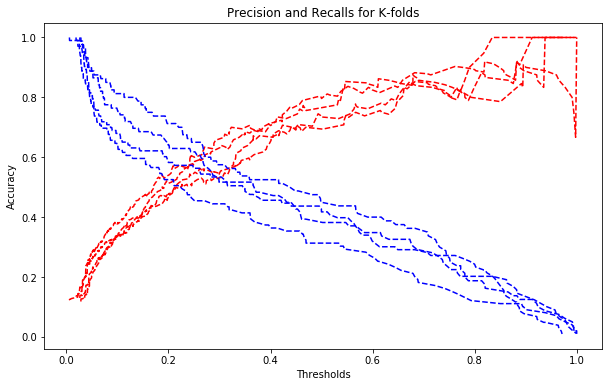

In [20]:
plt.figure(figsize = (10,6))
plt.plot(t_dict['t0'], p_dict['p0'], 'r--',
         t_dict['t1'], p_dict['p1'], 'r--',
         t_dict['t2'], p_dict['p2'], 'r--',
         t_dict['t3'], p_dict['p3'], 'r--',
         t_dict['t0'], r_dict['r0'], 'b--',
         t_dict['t1'], r_dict['r1'], 'b--',
         t_dict['t2'], r_dict['r2'], 'b--',
         t_dict['t3'], r_dict['r3'], 'b--')
plt.title('Precision and Recalls for K-folds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
# plt.axvline(0.6, color = 'darkred')
# plt.axvline(0.25, color = 'red')
# plt.axvline(0.15, color = 'yellow')
plt.show();

The plot shows the results of four different folds of the training data. The X-axis denotes the thresholds selected to flag an event as a 'negative rain event' and the y-axis shows the accuracy rate for the respective curve. The precision curves are shown in red, and the recall curves are shown in blue. As expected, the threshold for flagging an event increases, the precision (accuracy of the prediction) increases, but this occurs as the expense of the recall rate (total % of events identified correctly).

On this chart, I am interested whether there are optimal points in the curve to designate a decision threshold. The curves frrom each fold appear ot intersect around 0.25, which indicates that a prediction in this range has a similar likelihood of being correct or incorrect. The precision curve flattens out around 0.6, suggesting minimal gains to accuracy beyond this threshold. The recall curve seems to flatten out around 0.15, suggesting that the model performs similarly with a threshold beyond this point. These threshold level can be visualized below.

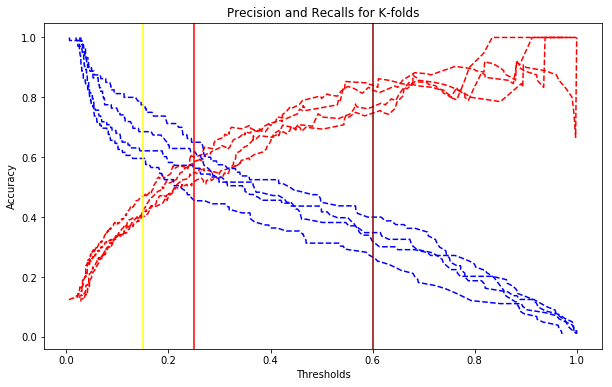

In [21]:
plt.figure(figsize = (10,6))
plt.plot(t_dict['t0'], p_dict['p0'], 'r--',
         t_dict['t1'], p_dict['p1'], 'r--',
         t_dict['t2'], p_dict['p2'], 'r--',
         t_dict['t3'], p_dict['p3'], 'r--',
         t_dict['t0'], r_dict['r0'], 'b--',
         t_dict['t1'], r_dict['r1'], 'b--',
         t_dict['t2'], r_dict['r2'], 'b--',
         t_dict['t3'], r_dict['r3'], 'b--')
plt.title('Precision and Recalls for K-folds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.axvline(0.6, color = 'darkred')
plt.axvline(0.25, color = 'red')
plt.axvline(0.15, color = 'yellow')
plt.show();

Next, I was interested in observing the average accuracy rate for negative rain events and normal days across each fold of the model. The code block below computes the accuracy rate of each threshold, averaging across folds.

In [22]:
X_array = np.array(X)
#Loop through dictionary to train the model on different folds
model_dict = {}
neg_accuracy = []
pos_accuracy = []
threshold_list = []
for f in range(folds):
    #Create the training and test sets
    X_train = X_array[kfold_idx['train{0}'.format(f)]]
    y_train = y[kfold_idx['train{0}'.format(f)]]
    X_test = X_array[kfold_idx['test{0}'.format(f)]]
    y_test = y[kfold_idx['test{0}'.format(f)]]
    
    #Standardize the data, add dummy feature
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    #Train the model
    model = linear_model.LogisticRegressionCV()
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    for threshold in np.linspace(0,1,100,endpoint=False):
        y_pred = adjusted_classes(y_scores, threshold)
        c_mat = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = c_mat.ravel()
        neg_accuracy.append(tn / (tn +fn))
        pos_accuracy.append(tp / (tp + fp))
        threshold_list.append(threshold)
model_dict['p'] = pos_accuracy
model_dict['n'] = neg_accuracy
model_dict['t'] = threshold_list

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

/Users/danielwhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

/Users/danielwhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/Users/danielwhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

/Users/danielwhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

/Users/danielwhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


In [23]:
threshold_df = pd.DataFrame({'threshold' : model_dict['t'],
                       'n' : model_dict['n'],
                       'p' : model_dict['p']})
threshold_df.head()

,threshold,n,p
0,0.00,NaN,0.083507
1,0.01,1.000000,0.104849
2,0.02,1.000000,0.109290
3,0.03,0.997024,0.127010
4,0.04,0.984018,0.140385


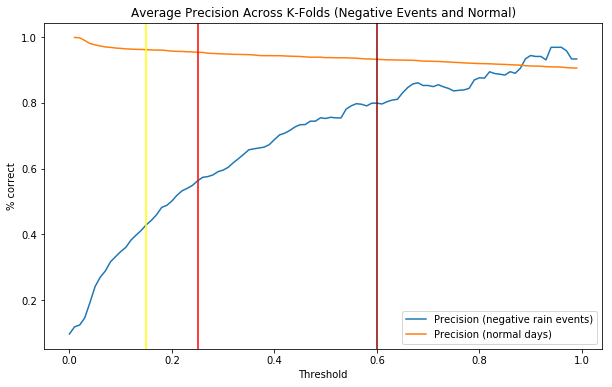

In [24]:
t_group = threshold_df.groupby('threshold')[['n','p']].mean()
plt.figure(figsize = (10,6))
plt.plot(t_group.index, t_group.p, 
         t_group.index, t_group.n)
plt.legend(['Precision (negative rain events)', 
            'Precision (normal days)'])
plt.xlabel('Threshold')
plt.ylabel('% correct')
plt.title('Average Precision Across K-Folds (Negative Events and Normal)')
plt.axvline(0.6, color = 'darkred')
plt.axvline(0.25, color = 'red')
plt.axvline(0.15, color = 'yellow')
plt.show();

The chart shows that the model can correctly identify normal days at a high rate (not surprising, as many days had no precipitation). The threshold selected also seem to align well with the average precision observed across all folds. The plot shows a proposed threshold system based on the risk associated with each day.

* **Very High** - Decision function over 0.6

* **High** - Decision function over 0.25, but less than 0.6

* **Medium** - Decision function over 0.15, but less than 0.25

* **Low** - Decision function below 0.15

In [25]:
very_high = 0.6
high = 0.25
medium = 0.15
def threat_level(input_probability):
    if input_probability >= very_high:
        return 'Very High'
    if ((input_probability >= high) & (input_probability < very_high)):
        return 'High'
    if ((input_probability >= medium) & (input_probability < high)):
        return 'Medium'
    return 'Low'

## Testing Thresholds on Historical Data

In this section, I test the thresholds proposed above on the historical data to better understand how they should be interpreted. First, I looked at the distribution of values for the decision function. On more than half of days, the decision function had a value of less than 0.05 with a right skew on higher values.

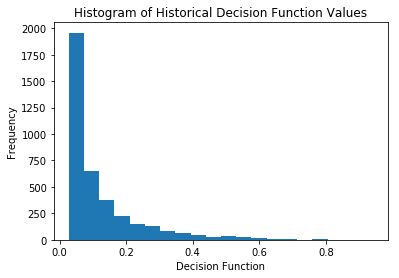

In [26]:
y_scores = model.predict_proba(X)[:,1]
plt.hist(y_scores, bins=20)
plt.title('Histogram of Historical Decision Function Values')
plt.xlabel('Decision Function')
plt.ylabel('Frequency')
plt.show();

The output below shows how frequently each threat level was predicted. 75% of days are categorized as Low, 12% as Medium, 11% as High, and 1% as Very High.

In [27]:
historical_predictions = pd.DataFrame({'y_scores' : y_scores,
                                      'y': y})
historical_predictions['threat'] = historical_predictions['y_scores'].apply(threat_level)
historical_predictions['threat'].value_counts(normalize=True)

Low          0.751762
Medium       0.124772
High         0.114330
Very High    0.009136
Name: threat, dtype: float64

The output below shows the percentage of time a negative rain event occurred under each threat level. 

There is a high degree of certainty at the Very High threat level, with negative rain events occurring 95% of the time. Under a Low threat, 4% of days observed a negative rain event.

In [28]:
historical_predictions.groupby('threat')['y'].mean()

threat
High         0.417808
Low          0.030556
Medium       0.140167
Very High    0.942857
Name: y, dtype: float64

The percentage of negative rain events that occurred under these threats levels is summarized above. There is a high degree of certainty at the High and Very High levels. Under a Low threat level, 4% of days were negative rain events.

In [29]:
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    
    mat = confusion_matrix(y, y_pred_adj)

    tn, fp, fn, tp = mat.ravel()
    print('\n', 'Threshold: ', t)
    print('Prediction Frequency: ', (tp + fp) / np.sum(mat) )
    print('Model Score: ', (tp + tn) / np.sum(mat))

    #Of the predicted positives, how many were correct
    print('Model Precision: ', tp/ (tp + fp))

    #How many actual positives did we predict correctly.
    print('Model Recall Rate: ', tp / (tp + fn))
    print(pd.DataFrame(mat,
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

Additional evaluations are presented below, showing the precision and recall rates of the thresholds used for each threat level.

In [30]:
precision_recall_threshold(p, r, thresholds, 0.6)
precision_recall_threshold(p, r, thresholds, 0.25)
precision_recall_threshold(p, r, thresholds, 0.15)


 Threshold:  0.6
Prediction Frequency:  0.009135995823544766
Model Score:  0.9112503262855651
Model Precision:  0.9428571428571428
Model Recall Rate:  0.0889487870619946
     pred_neg  pred_pos
neg      3458         2
pos       338        33

 Threshold:  0.25
Prediction Frequency:  0.12346645784390499
Model Score:  0.892456277734273
Model Precision:  0.45665961945031713
Model Recall Rate:  0.5822102425876011
     pred_neg  pred_pos
neg      3203       257
pos       155       216

 Threshold:  0.15
Prediction Frequency:  0.24823805794831635
Model Score:  0.8026624902114331
Model Precision:  0.29758149316508936
Model Recall Rate:  0.7628032345013477
     pred_neg  pred_pos
neg      2792       668
pos        88       283


## Interpretation of Threat Levels

* **Very High**: Certainty of negative event is statistically significant, historically there is a 95% chance of a negative rain event under this threat level. This level of prediction is only made on 1% of days in the year.


* **High**: On all days classified as High, there is a ~42% chance of a negative rain event. About 58% of total negative events observed occurred under High and Very High threat levels. The "High" threat level is applied on ~11% of days.


* **Medium**: On days classified as Medium, there was a ~15% chance of a negative rain event. About 76% of total negative events observed occurred under Medium, High, and Very High threat levels. The "Medium" threat level is made on ~12.5% of days.


* **Low**: The most common prediction (83% of days). A negative event has about a 4% chance of occurring.

Threat levels in the model can be easily adjusted based on the needs of the user. The Very High threat level can be used to identify negative rain events at a high level of certainty. The High threat level can identify nearly 60% of negative rain events, while being accurate more than 40% of the time. The threat levels should be interpreted depending on their predictive needs. If the cost of predicting a negative event and being wrong is high, use the Very High threshold because it's more accurate. If the cost of missing a negative event prediction is high, use the High threshold to correctly identify more events.

## Key Metrics

Overall, the model is more effective at identifying events than the previously used heuristics.

* Under the Very High desigination alone, we improved over the 2 inches in 24 heuristic by 3 times as many rain events correctly with a similar degree of certainty.

* The model can identify about 58% of events using when responding to days with High/Very High designations. The previously used '2 inch in 24 hours' heuristic only identified 3% of negative rain events. 



## Predictions Based on NAEFS Forecast Data

### NAEFS Data Overview

The NAEFS forecast data is available for download at the link here: http://dd.weather.gc.ca/ensemble/naefs/xml/

1. Select the desired date of forecast data (most recent at the very bottom)

2. The 00/ and 12/ folders refer to the forecast time (UTC). As a rule of thumb, UTC is 8 hours ahead of Pacific Time, thus 00 refers to 4pm, Seattle time on the previous day and 12/ is 4am Seattle time.

3. The forecasts for accumulated precipitation at the surface (APCP) are located in the APCP-SFC/ folder. After clicking into this folder, select the raw/ folder and scroll to Seattle in the alphabetically sorted list of locations.

4. The file will download as bz2 zipped folder. The folder can be unzipped with the 7-Zip software for Windows, or by double clicking on Mac.

The contents of the .xml forecast file can be viewed as a text file. The functions below parse the xml file, averaging the precipitations forecasts from various models and saves them as a dataframe. Note that the forecast values are provided in millimeters and then are converted to inches.

Additional documentation on the NAEFS forecast data is available here:
http://dd.weather.gc.ca/ensemble/doc/naefs/README_naefs-spena_xml.txt

### NAEFS Forecast Data Processing
The functions below parse the XML file, process the data for modeling, and generate the prediction for a negative rain event

In [31]:
#Parse the XML file, return dataframe with hourly precipitation data.
def parse_forecast_xml(file_name):
    '''Takes in the NAEFS xml file, returns dataframe with forecast preciptiation by 6 hour period'''
    #Import necessary packages
    import xml.etree.ElementTree as ET
    import numpy as np
    import pandas as pd
    from datetime import datetime
    
    #Parse the XML file
    tree = ET.parse(file_name)
    root = tree.getroot()
    forecast_time = []
    precip = []
    for child in root:
        for element in child:
            try:
                forecast_time.append(child.attrib['valid_time'])
                precip.append(float(element.text))
            except(KeyError):
                forecast_time.append(np.nan)
                precip.append(np.nan)
    
    #Create dataframe of precipitation for each period
    raw_forecast_df = pd.DataFrame(data = {'time' : forecast_time, 
                                       'precip' : precip})
    #Take the average of all models, convert from mm to inches
    forecast_df = pd.DataFrame(raw_forecast_df.groupby('time')['precip'].mean())
    forecast_df['precip_in'] = forecast_df['precip'].map(lambda x:  x * 0.0393701)
    
    #Calculate marginal precipitation, get rid of NaN value in first row
    forecast_df['total_rain'] = forecast_df['precip_in'].diff()
    idx = np.where(forecast_df['total_rain'].isnull())
    if ((len(idx) == 1) & (int(idx[0]) == 0)):
        forecast_df['total_rain'].fillna(forecast_df['precip_in'][0], inplace = True)
    else:
        print('Parsing Error. Too many NAs in XML file')
    
    #Create date from time string
    df = forecast_df.reset_index()
    df['datetime'] = df['time'].map(lambda x :datetime.strptime(x,'%Y%m%d%H'))
    df['day'] = df['datetime'].map(lambda x : x.date())
    df['period'] = df['datetime'].map(lambda x : x.hour)
    df['total_rain'] = round(df['total_rain'],3)
    df = df[['day', 'period', 'total_rain']]
    return df

In [32]:
def create_forecast_X(training_X, training_y, forecast_data):
    """
    Create the forecast X dataframe to be used for prediction
    The forecast data has to be standarized based on the training set of historical predictions
    """

    #Split training data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(training_X, training_y, random_state=0)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    #Standardize the forecast data based on X_train
    forecast_X = scaler.transform(forecast_data)
    return forecast_X

In [33]:
def historic_probability(decision):
    """
    Calculate the probability of negative event based historical weather data
    Value should be interpreted as 'On days as bad or worse than this one, there was an event X% of the time
    """
    hist_prediction = model.predict_proba(X_array)[:,1]
    hist_actual = y
    similar_days = [1 if h >= decision else 0 for h in hist_prediction]
    hist_df = pd.DataFrame({'similar_days': similar_days,
                 'hist_actual' : hist_actual})
    return np.mean(hist_df[hist_df['similar_days'] == 1]['hist_actual'])

In [34]:
def create_prediction_df(forecast_X, forecast):
    """
    Create the prediction dataframe, calculate the threat level and historic probability 
    using the model's decision function
    """
    forecast_predictions = model.predict_proba(forecast_X)
    predict_df = pd.DataFrame(forecast['total_rain'])
    predict_df['decision_function'] = forecast_predictions[:,1]
    predict_df['threat'] = predict_df['decision_function'].apply(threat_level)
    predict_df['probability'] = predict_df['decision_function'].apply(historic_probability)
    #predict_df.index = forecast.index
    return predict_df

### Generate Predictions from Latest Forecast Data

This section generates the predictions from the forecast data. New forecasts can be inputted by changing the file name in the code block below.

In [36]:
#Enter most recent NAEFS forecast file name below
naefs = '2018122112_GEPS-NAEFS-RAW_SEATTLE_WA_US_APCP-SFC_000-384.xml'

In [37]:
#Parse XML of new forecast data
forecast = parse_forecast_xml(naefs)
forecast.head()

,day,period,total_rain
0,2018-12-21,18,0.012
1,2018-12-22,0,0.012
2,2018-12-22,6,0.016
3,2018-12-22,12,0.039
4,2018-12-22,18,0.027


In [38]:
# Create X and y dataframes
df = pd.merge(historical_rain_df, maximo_tms, how = 'inner', left_index = True, right_index = True)
y = np.array(df['work_orders'])
y_rule = df['work_orders'].quantile(.9)
y = np.greater(y, y_rule)*1
del df['work_orders']
X = df.fillna(0)

#Create the logistic regression model
model = create_model(X,y)

#Generate features to be used in model from forecast data
forecast_df = generate_features(forecast)

#Standardize the forecast data using the historical data
forecast_X = create_forecast_X(X,y, forecast_df)

#Create the predictions, display the dataframe
prediction_df = create_prediction_df(forecast_X, forecast_df)
prediction_df

,total_rain,decision_function,threat,probability
day,,,,
2018-12-21,0.012,0.037369,Low,0.108480
2018-12-22,0.094,0.022213,Low,0.096842
2018-12-23,0.605,0.164849,Medium,0.360923
2018-12-24,0.393,0.539412,High,0.916667
2018-12-25,0.163,0.178962,Medium,0.380665
2018-12-26,0.160,0.169007,Medium,0.361227
2018-12-27,0.280,0.219050,Medium,0.448980
2018-12-28,0.165,0.094593,Low,0.218665
2018-12-29,0.459,0.195132,Medium,0.408621


The dataframe above shows predictions for negative rain events based on the forecast for precipitation. The threat level interpretations are reiterated below. 

* **Very High**: Certainty of negative event is statistically significant, historically there is a 95% chance of a negative rain event under this threat level. This level of prediction is only made on 1% of days in the year.


* **High**: On all days classified as High, there is a ~42% chance of a negative rain event. About 58% of total negative events observed occurred under High and Very High threat levels. The "High" threat level is applied on ~11% of days.


* **Medium**: On days classified as Medium, there was a ~15% chance of a negative rain event. About 76% of total negative events observed occurred under Medium, High, and Very High threat levels. The "Medium" threat level is made on ~12.5% of days.


* **Low**: The most common prediction (83% of days). A negative event has about a 4% chance of occurring.


The probability value should be interpreted as follows:

"Based off the model features, on days as bad or worse than this one, there was an X% probability of a negative rain event." 

This variable is designed to gauge where a particular day falls within the threat level scale.


## Future Work / References

Some notes for future work and references are included below.

* Test model on combined sewer overflow data
* Try new features, i.e. time of day when max period occurs, weekend vs. weekday indicator instead of day of week
* New historical data, wind speed could also be indicative of days with high work orders is also available in the NAEFS forecast

References: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65